# 10x heart fit, whole-dataset


In this notebook, we fit a model with bursty transcription, splicing, and degradation, coupled to a length-dependent Poisson model of sequencing. We analyze the three 10x heart datasets.

## Prerequisites

Load in *Monod*.


In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

## Metadata

Define metadata and directories.

In [3]:
dataset_meta = ['heart_' + x for x in ['1k_v2','1k_v3','10k_v3']]

dataset_names = [x for x in dataset_meta ]  
raw_data_locations = [x for x in dataset_meta]
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [4]:
dataset_names

['heart_1k_v2', 'heart_1k_v3', 'heart_10k_v3']

## Filtering

Perform a round of filtering based on the knee plot.


In [6]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

Dataset heart_1k_v2. 
	743 barcodes in loom, 703 pass filter.
Dataset heart_1k_v3. 
	982 barcodes in loom, 976 pass filter.
Dataset heart_10k_v3. 
	7462 barcodes in loom, 7402 pass filter.


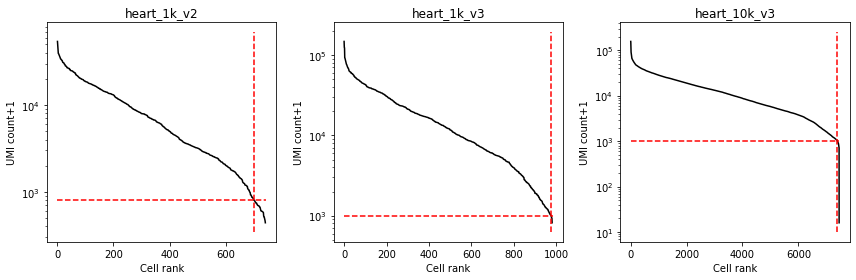

In [8]:
cf = []
thr_lb = [8e2,1e3,1e3]
S_arr = []
U_arr = []
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k ]
    dataset_name = raw_data_locations[k ]
        
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter.')
        S_arr.append(S)
        U_arr.append(U)

        cf.append(cf_)

    ax1[k].set_title(dataset_name)
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_heart.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)


Inspect the summary statistics of v2 and v3 datasets. The two v3 look almost identical; v2 has lower mean and higher noise.


CV2.

/tmp/ipykernel_3037660/2925758706.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_3037660/2925758706.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


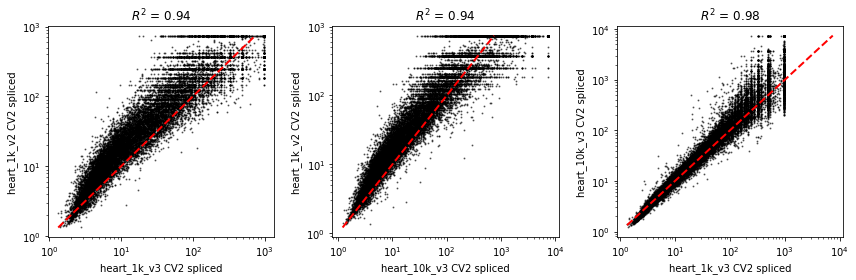

In [27]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = S_arr[k1]
    y = S_arr[k2]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' CV2 spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' CV2 spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

/tmp/ipykernel_3037660/2343931339.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_3037660/2343931339.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


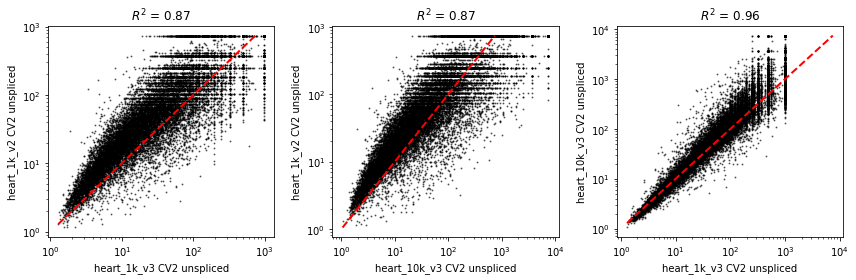

In [28]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = U_arr[k1]
    y = U_arr[k2]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' CV2 unspliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' CV2 unspliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Means.

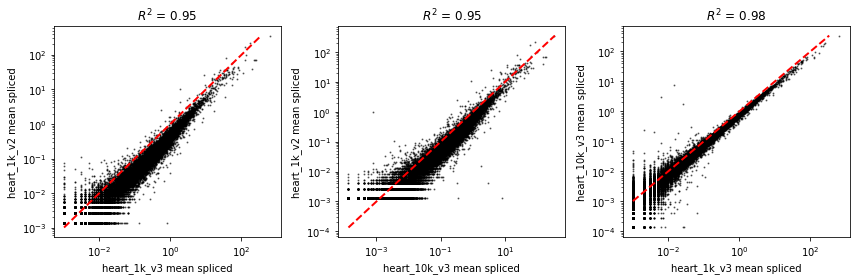

In [29]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = S_arr[k1]
    y = S_arr[k2]
    x = x.mean(1)
    y = y.mean(1)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

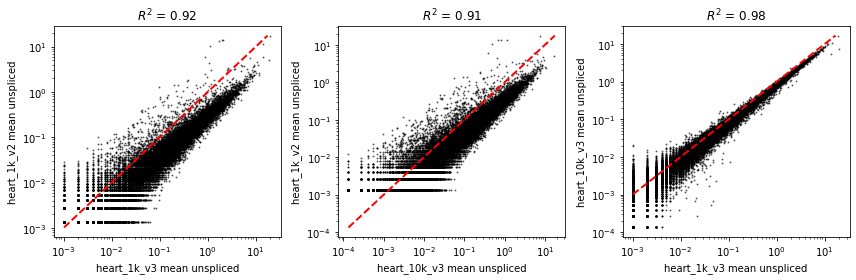

In [30]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = U_arr[k1]
    y = U_arr[k2]
    x = x.mean(1)
    y = y.mean(1)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean unspliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean unspliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [31]:
[x.sum() for x in cf]


[703, 976, 7402]

## Preprocessing

Create a batch and select genes to analyze.


In [7]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221115_025_heart_1 created.
INFO:root:Dataset: heart_1k_v2
INFO:root:703 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:2612 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_1k_v2 created.
INFO:root:Dataset: heart_1k_v3
INFO:root:976 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6780 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_1k_v3 created.
INFO:root:Dataset: heart_10k_v3
INFO:root:7402 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:8408 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_10k_v3 created.
INFO:root:Total of 2500 genes selected.
INFO:root:Directory ./fits/gg

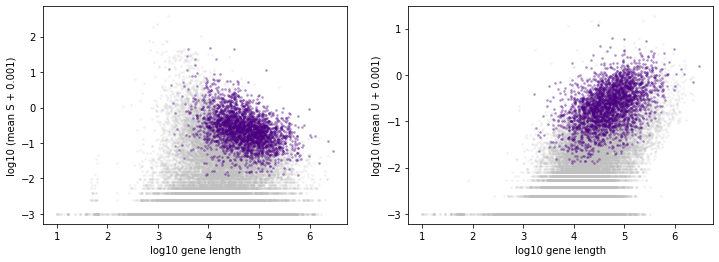

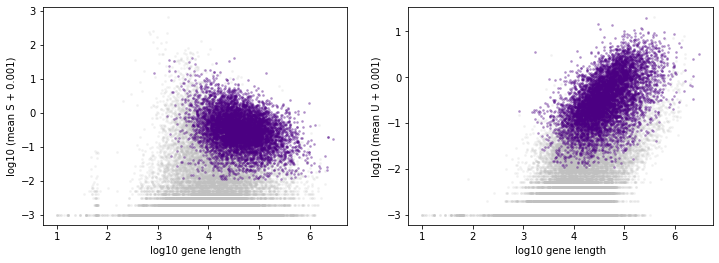

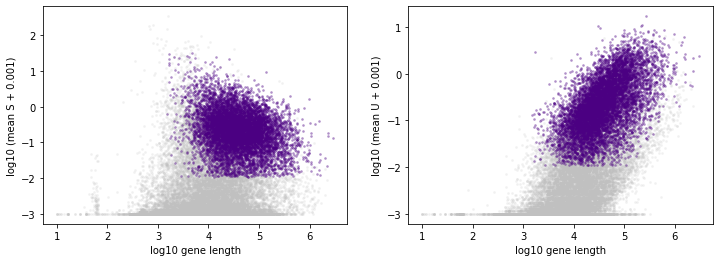

In [34]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='heart',batch_id=1,\
                                             n_genes=2500,exp_filter_threshold=None,cf=cf)

## Inference

Fit the model.


In [35]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: heart_1k_v2
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221115_025_heart_1/genes.csv.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_1k_v2/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221115_025_heart_1/heart_1k_v2/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [2:14:31<00:00, 19.22s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 8072.9 seconds.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_1k_v3/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221115_025_heart_1/heart_1k_v3/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: heart_1k_v3
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221115_025_heart_1/genes.csv.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_1k_v3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221115_025_heart_1/heart_1k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████| 420/420 [6:57:26<00:00, 59.63s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_1k_v3/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 25048.0 seconds.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_10k_v3/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221115_025_heart_1/heart_10k_v3/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: heart_10k_v3
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221115_025_heart_1/genes.csv.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_10k_v3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221115_025_heart_1/heart_10k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████| 420/420 [10:10:44<00:00, 87.25s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221115_025_heart_1/heart_10k_v3/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 36649.7 seconds.


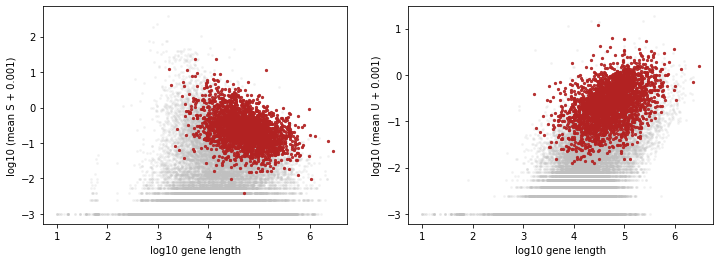

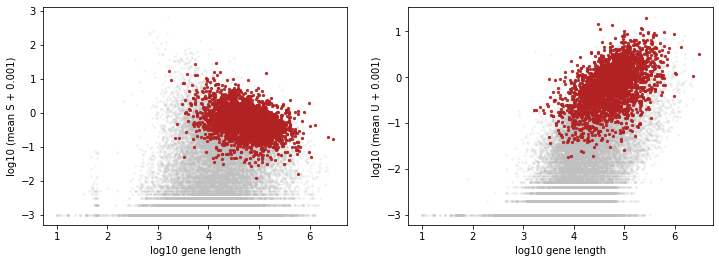

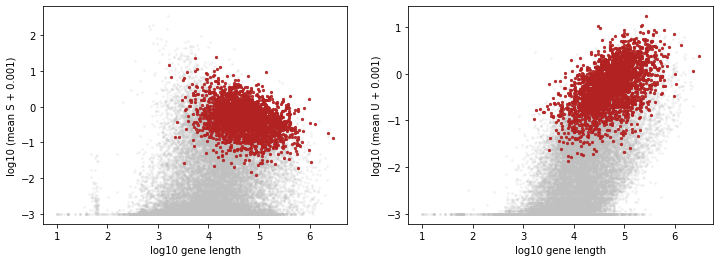

In [36]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-8, -2.5]
samp_ub = [-5, 0]
gridsize = [20,21]



result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':3})
#                 gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':3})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(42,search_data)
    result_strings.append(full_result_string)


## Post-processing

Load in data and do basic QC: test parameter trends, KLD landscapes, and goodness-of-fit.

In [37]:
dataset_names

['heart_1k_v2', 'heart_1k_v3', 'heart_10k_v3']

In [38]:
dir_string

'./fits/gg_221115_025_heart_1'

In [36]:
result_strings

['./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221115_025_heart_1/heart_1k_v3/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221115_025_heart_1/heart_10k_v3/Bursty_Poisson_20x21/grid_scan_results.res']

INFO:root:Grid scan results loaded from ./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221115_025_heart_1/heart_1k_v2/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 133 genes out of 2500. Runtime: 3.5 seconds.
INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -5.95, -0.50.
INFO:root:Chi-square computation complete. Rejected 133 genes out of 2500. Runtime: 3.5 se

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_1k_v2/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221115_025_heart_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221115_025_heart_1/heart_1k_v3/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221115_025_heart_1/heart_1k_v3/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_1k_v3/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_1k_v3/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 639 genes out of 2500. Runtime: 6.3 seconds.
INFO:root:Figure stored to ./fits/gg_221115_02

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_1k_v3/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_1k_v3/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221115_025_heart_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221115_025_heart_1/heart_10k_v3/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221115_025_heart_1/heart_10k_v3/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_10k_v3/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_10k_v3/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 75 genes out of 2500. Runtime: 12.0 seconds.
INFO:root:Figure stored to ./fits/gg_22111

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_10k_v3/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.


/home/ggorin/projects/monod/src/monod/inference.py:1003: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(nrows=1, ncols=num_params, figsize=figsize)


INFO:root:Figure stored to ./fits/gg_221115_025_heart_1/heart_10k_v3/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221115_025_heart_1/analysis_figures already exists.


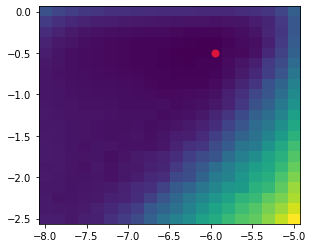

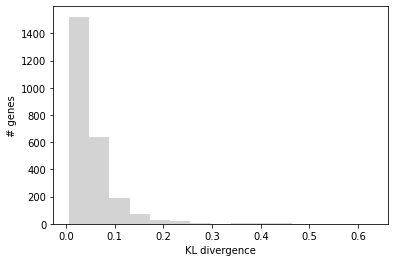

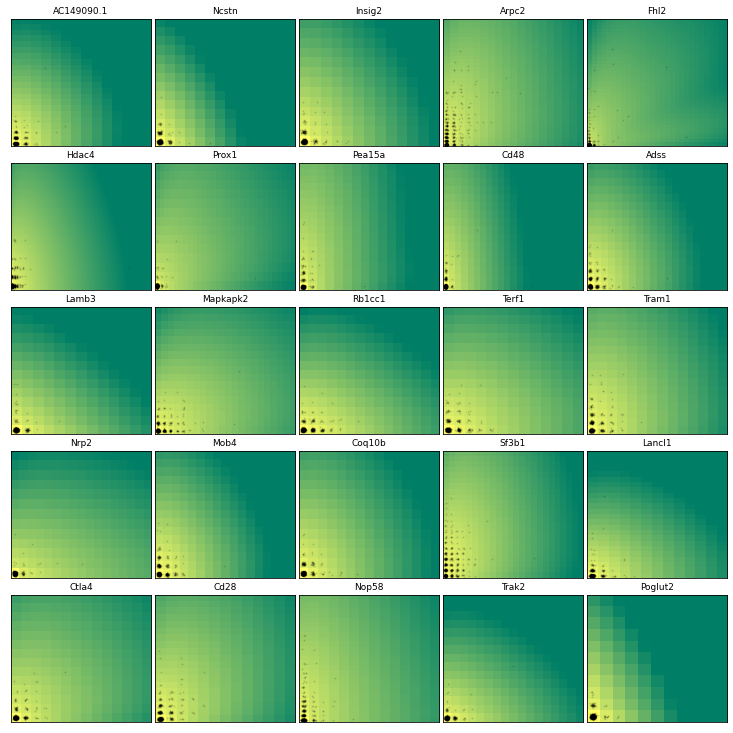

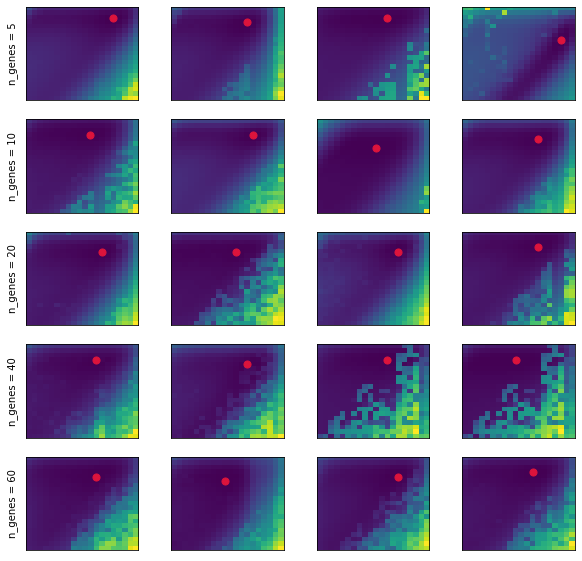

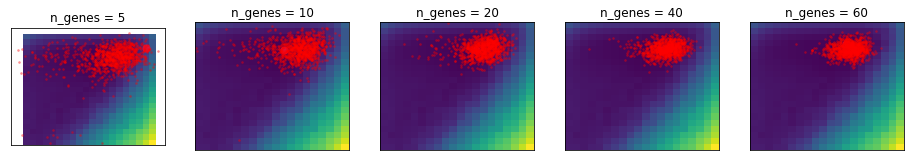

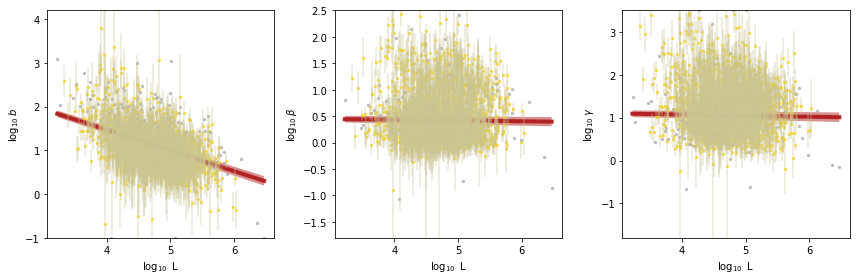

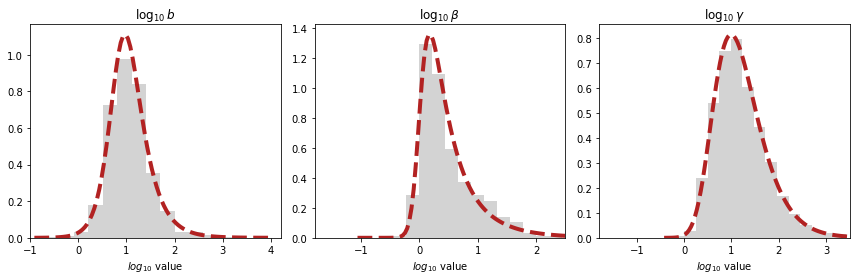

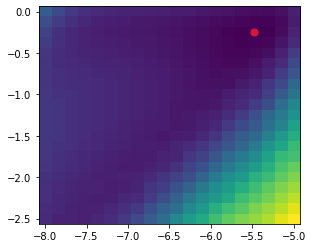

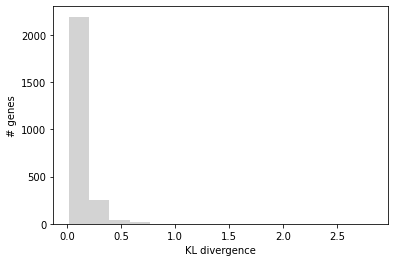

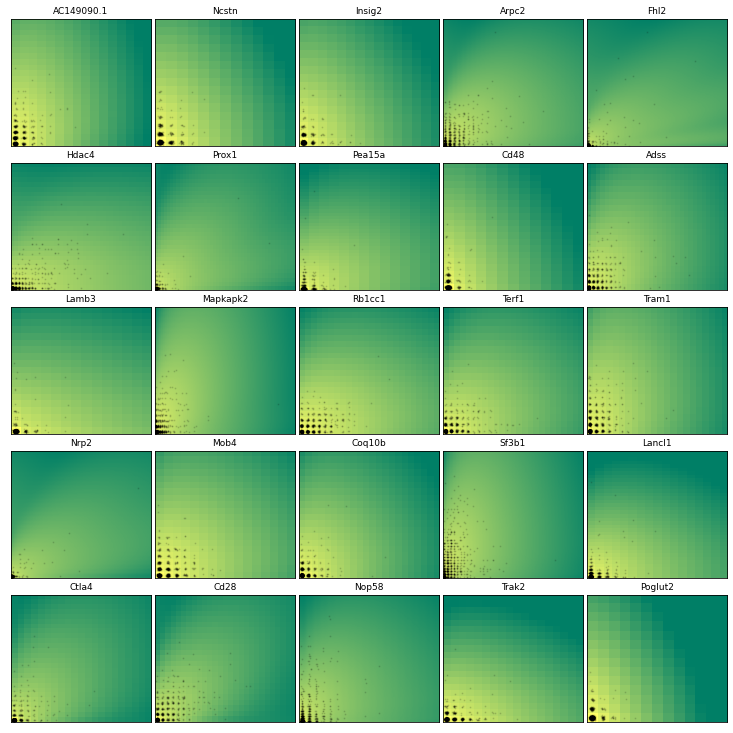

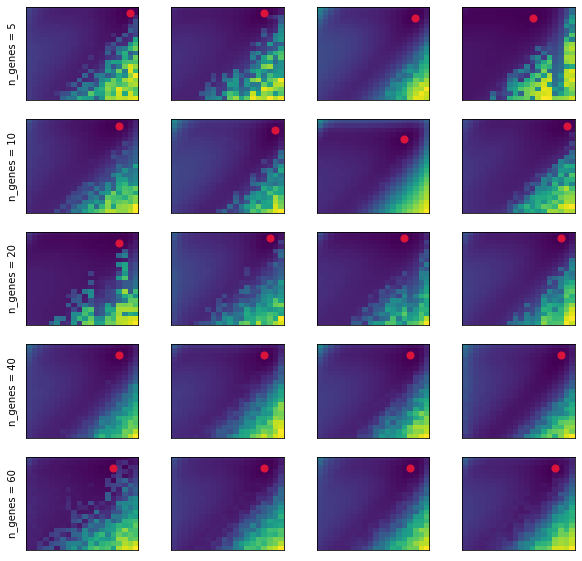

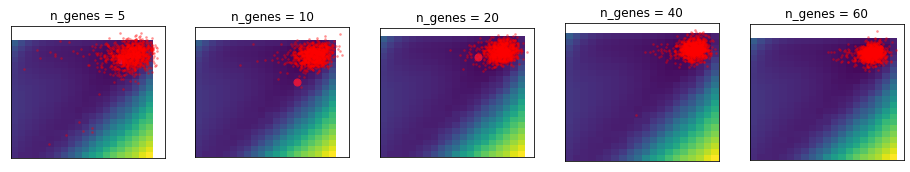

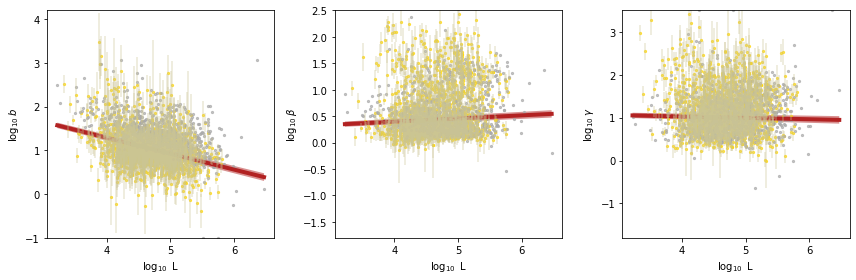

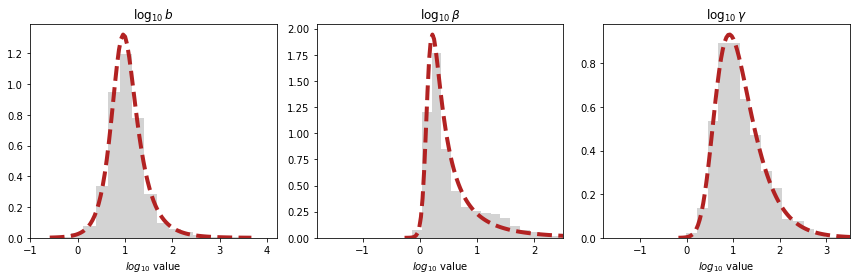

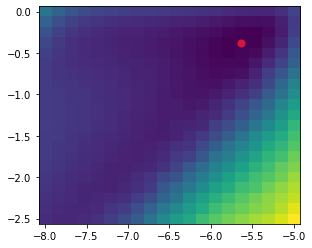

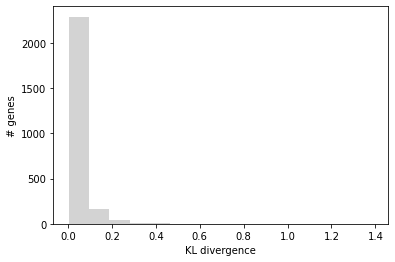

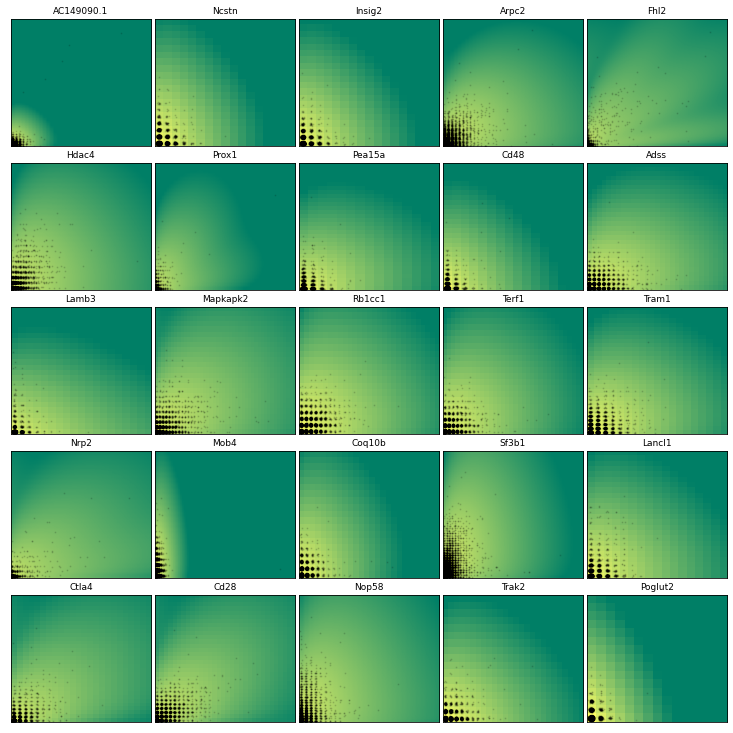

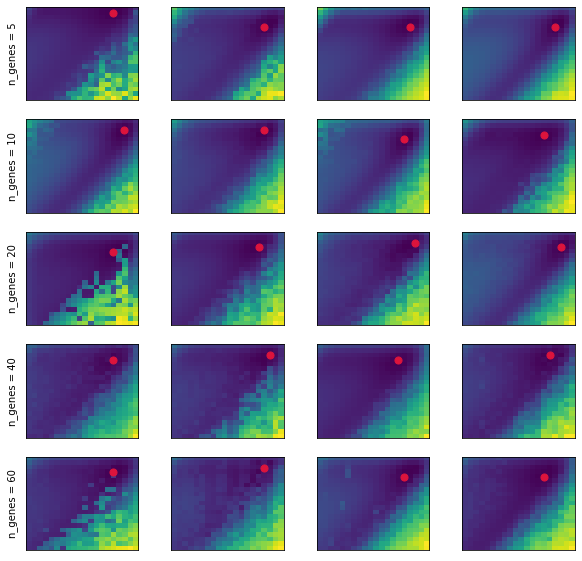

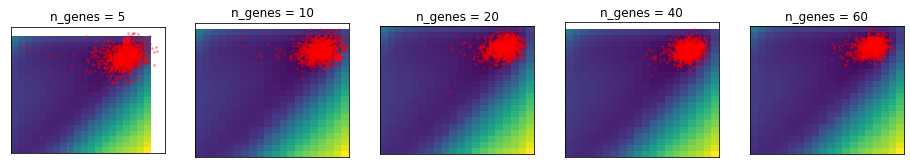

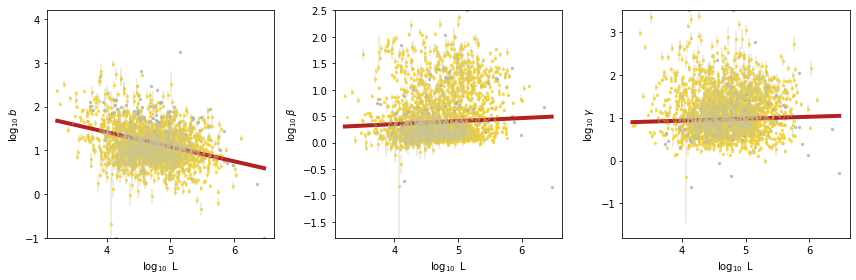

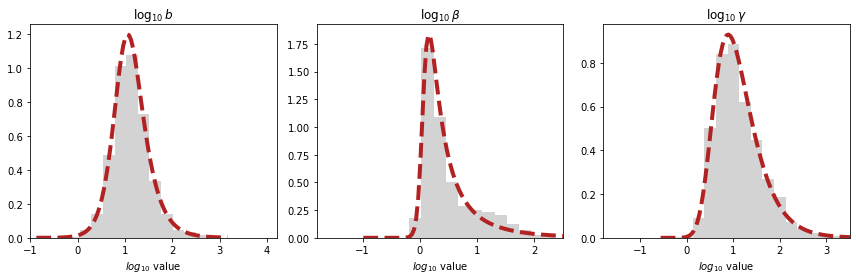

In [9]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01)

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


In [8]:
# dir_string = './fits/gg_221115_025_heart_1'
# result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results.res' for x in dataset_names]